In [1]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [3]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = 'data/'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


In [4]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
    start = time.time()
    print("Loading training images...")

    training_data = []
    faces_path = os.path.join(DATA_PATH,'images')
    for filename in tqdm(os.listdir(faces_path)):
        path = os.path.join(faces_path,filename)
        image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
        training_data.append(np.asarray(image))
    training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
    training_data = training_data.astype(np.float32)
    training_data = training_data / 127.5 - 1.


    print("Saving training image binary...")
    np.save(training_binary_path,training_data)
    elapsed = time.time()-start
    print (f'Image preprocess time: {hms_string(elapsed)}')
else:
    print("Loading previous training pickle...")
    training_data = np.load(training_binary_path)

Looking for file: data/training_data_64_64.npy
Loading previous training pickle...


In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-01-06 05:18:04.658896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-06 05:18:04.659000: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-06 05:18:04.659031: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (924be8630b35): /proc/driver/nvidia/version does not exist
2022-01-06 05:18:04.669584: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
        model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [7]:
def save_images(cnt,noise):
    image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)

    generated_images = generator.predict(noise)

    generated_images = 0.5 * generated_images + 0.5

    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
                = generated_images[image_count] * 255
            image_count += 1


    output_path = os.path.join(DATA_PATH,'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

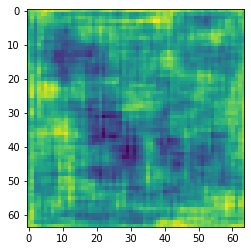

In [8]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [9]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5001335]], shape=(1, 1), dtype=float32)


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [12]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)


        gradients_of_generator = gen_tape.gradient(\
            gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(\
            disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(
            gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(
            gradients_of_discriminator, 
            discriminator.trainable_variables))
    return gen_loss,disc_loss

In [13]:
def train(dataset, epochs):
    fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
    start = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
               f' {hms_string(epoch_elapsed)}')
        save_images(epoch,fixed_seed)

    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')

In [14]:
train(train_dataset, EPOCHS)

2022-01-06 05:18:30.199670: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1, gen loss=2.310373306274414,disc loss=0.9776051044464111, 0:13:11.94
Epoch 2, gen loss=2.58000111579895,disc loss=0.8042697310447693, 0:12:40.38
Epoch 3, gen loss=2.2430570125579834,disc loss=0.9294167757034302, 0:12:37.43
Epoch 4, gen loss=1.9666825532913208,disc loss=0.9753084182739258, 0:12:45.65
Epoch 5, gen loss=1.9868149757385254,disc loss=0.9805097579956055, 0:12:37.15
Epoch 6, gen loss=2.031205415725708,disc loss=0.9532597661018372, 0:13:22.48
Epoch 7, gen loss=2.02156662940979,disc loss=0.9142941236495972, 0:12:35.02
Epoch 8, gen loss=2.0608811378479004,disc loss=0.9084380269050598, 0:12:42.74
Epoch 9, gen loss=2.0980224609375,disc loss=0.8488625288009644, 0:12:37.56
Epoch 10, gen loss=2.1544477939605713,disc loss=0.8103958368301392, 0:12:37.76
Epoch 11, gen loss=2.1960201263427734,disc loss=0.8216128349304199, 0:12:36.67
Epoch 12, gen loss=2.228930711746216,disc loss=0.8319682478904724, 0:12:37.86
Epoch 13, gen loss=2.23305082321167,disc loss=0.8027093410491943, 0:12:

In [15]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))